In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
import itertools
from cnn2 import WindFaultDataset, WindFaultCNN, test_model, validate_model, train_model, prepare_datasets

In [10]:
param_grid = {
    'window_size': [5, 10, 15, 20],  # Test smaller window sizes
    'overlap_size': [0, 2, 5],        # Relative to window size
    'learning_rate': [0.001, 0.005],
    'batch_size': [32, 64],
    'num_epochs': [30, 50],          # Increased epochs for smaller windows
    'optimizer': ['Adam']
}

4-9 grid search attempt


Testing params: (5, 0, 0.001, 32, 30, 'Adam')
Epoch 1, Loss: 1.6095199926798347
Epoch 2, Loss: 1.6092492480812461
Epoch 3, Loss: 1.608549257032736
Epoch 4, Loss: 1.6011204034133422
Epoch 5, Loss: 1.5894285825662737
Epoch 6, Loss: 1.5853560212050637
Epoch 7, Loss: 1.577732281913924
Epoch 8, Loss: 1.5735015681737374
Epoch 9, Loss: 1.5586621239022223
Epoch 10, Loss: 1.556615632694361
Epoch 11, Loss: 1.5644404242652994
Epoch 12, Loss: 1.5479476854443723
Epoch 13, Loss: 1.5434975851397674
Epoch 14, Loss: 1.5405187417673059
Epoch 15, Loss: 1.5388427771508606
Epoch 16, Loss: 1.5348603536294885
Epoch 17, Loss: 1.5297373293789194
Epoch 18, Loss: 1.5295347228667968
Epoch 19, Loss: 1.5314398971013454
Epoch 20, Loss: 1.5257574137641874
Epoch 21, Loss: 1.5249110590422519
Epoch 22, Loss: 1.5284874442709933
Epoch 23, Loss: 1.5185065982643693
Epoch 24, Loss: 1.5221837337360633
Epoch 25, Loss: 1.5231139871577855
Epoch 26, Loss: 1.5259194375819687
Epoch 27, Loss: 1.5224087701614246
Epoch 28, Loss: 1.52

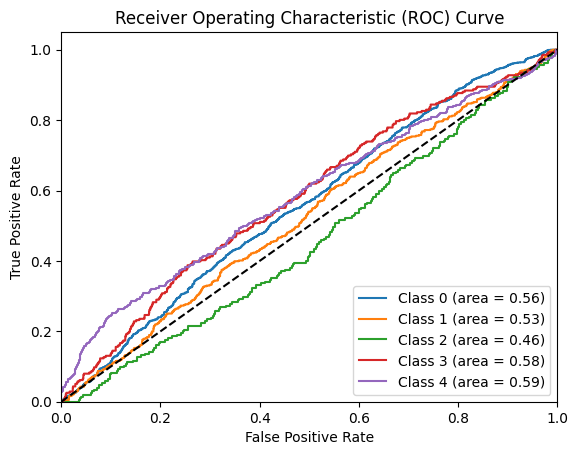

Final Test Accuracy: 0.5011
              precision    recall  f1-score   support

           0     0.5132    0.9573    0.6682      1404
           1     0.8000    0.0081    0.0161       491
           2     0.0000    0.0000    0.0000       205
           3     0.1923    0.0181    0.0331       276
           4     0.4097    0.1335    0.2014       442

    accuracy                         0.5011      2818
   macro avg     0.3830    0.2234    0.1838      2818
weighted avg     0.4782    0.5011    0.3705      2818



In [ ]:
best_accuracy = 0
best_params = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter search loop
for params in itertools.product(*param_grid.values()):
    window_size, overlap_size, lr, batch_size, num_epochs, optimizer_name = params
    print(f"\nTesting params: {params}")
    
    try:
        # Prepare datasets
        train_dataset, val_dataset, test_dataset = prepare_datasets(
            csv_path='combined_balanced_dataset.csv',
            label_column='Fault_Type',
            window_size=window_size,
            overlap_size=overlap_size,
            test_size=0.2,
            val_size=0.25
        )
        
        # Calculate class weights
        class_counts = np.bincount(train_dataset.labels)
        total_samples = class_counts.sum()
        num_classes = len(class_counts)
        class_weights = torch.tensor(total_samples / (num_classes * class_counts), dtype=torch.float32)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        num_features = train_dataset.data.shape[2]
        model2 = WindFaultCNN(
            input_channels=num_features,
            num_classes=num_classes,
            window_size=window_size
        ).to(device)

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model2.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model2.parameters(), lr=lr)

        # Train and validate
        #train_model(model, train_loader, num_epochs, optimizer, class_weights, device)
        val_accuracy = validate_model(model2, val_loader, class_weights, device)
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params
            torch.save(model2.state_dict(), 'best_model.pth')
            print(f"New best accuracy: {best_accuracy:.4f}")

    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        continue

# Evaluate best model on test set
print(f"\nBest parameters: {best_params}")
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path='combined_balanced_dataset.csv',
    label_column='Fault_Type',
    window_size=best_params[0],
    overlap_size=best_params[1]
)

test_loader = DataLoader(test_dataset, batch_size=best_params[3], shuffle=False)
best_model = WindFaultCNN(
    input_channels=train_dataset.data.shape[2],
    num_classes=len(np.unique(train_dataset.labels)),
    window_size=best_params[0]
).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

class_counts = np.bincount(train_dataset.labels)
class_weights = torch.tensor(class_counts.sum() / (len(class_counts) * class_counts), dtype=torch.float32)
# Note that evaluate model is deprecated, now use test_model
final_accuracy, report, conf_matrix, roc_auc = evaluate_model(
    best_model, test_loader, 
    nn.CrossEntropyLoss(weight=class_weights.to(device)),
    len(class_counts)
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

Try that best run with 100 epochs. Or in a loop to keep going if loss does not go down anymore. 

WindFaultCNN(
  (conv1): Conv1d(19, 16, kernel_size=(3,), stride=(1,), padding=same)
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=7)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)
Epoch 1/100 | Train Loss: 1.6098 | Val Loss: 1.6090
Epoch 2/100 | Train Loss: 1.6094 | Val Loss: 1.6090
Epoch 3/100 | Train Loss: 1.6093 | Val Loss: 1.6090
Epoch 4/100 | Train Loss: 1.6092 | Val Loss: 1.6090
Epoch 5/100 | Train Loss: 1.6093 | Val Loss: 1.6090
Epoch 6/100 | Train Loss: 1.6095 | Val Loss: 1.6091
Epoch 7/100 | Train Loss: 1.6093 | Val Loss: 1.6090
Epoch 8/100 | Train Loss: 1.6092 | Val Loss: 1.6091
Epoch 9/100 | Train Loss: 1.6092 | Val Loss: 1.6079
Epoch 10/100 | Train Loss: 1.6077 | Val Loss: 1.6042
Epoch 11/100 | Train Loss: 1.6059 | Val Loss: 1.6040
Epoch 12/100 | Train Loss: 1.6043 | Val Loss: 1.6017
Epoch 1

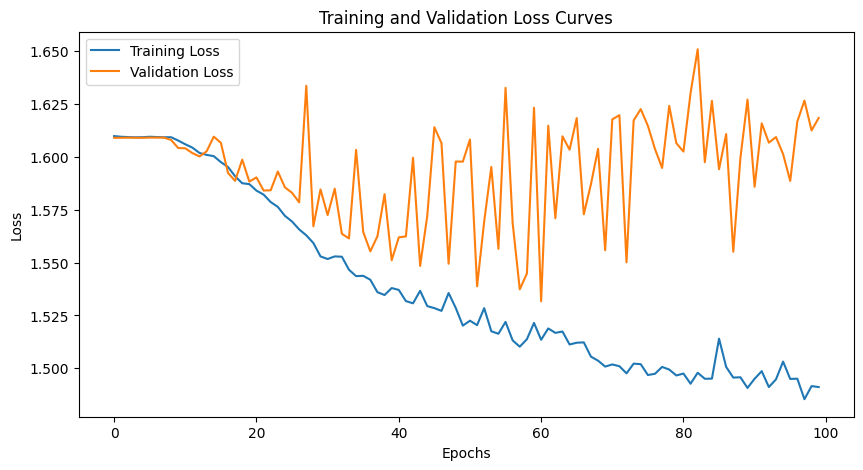

Training complete.
Test Loss: 1.5801
Test Accuracy: 0.2300

Classification Report:
               precision    recall  f1-score   support

           0     0.5912    0.1823    0.2787      1404
           1     0.2564    0.0204    0.0377       491
           2     0.0514    0.1756    0.0796       205
           3     0.1389    0.5471    0.2216       276
           4     0.3488    0.4412    0.3896       442

    accuracy                         0.2300      2818
   macro avg     0.2774    0.2733    0.2014      2818
weighted avg     0.4113    0.2300    0.2340      2818


Confusion Matrix:
 [[256  25 415 526 182]
 [133  10 154 144  50]
 [ 12   1  36 100  56]
 [ 18   1  30 151  76]
 [ 14   2  65 166 195]]


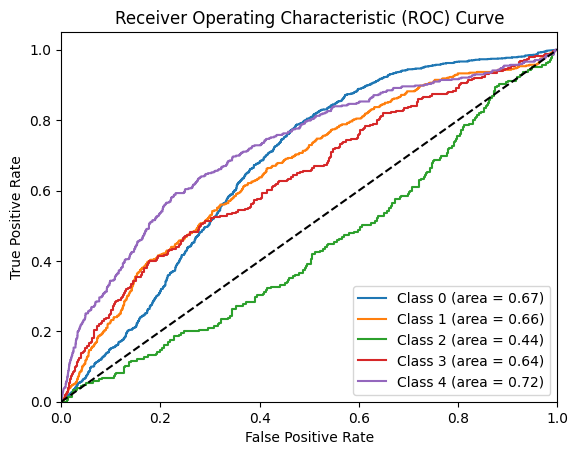

Final Test Accuracy: 0.2300
              precision    recall  f1-score   support

           0     0.5912    0.1823    0.2787      1404
           1     0.2564    0.0204    0.0377       491
           2     0.0514    0.1756    0.0796       205
           3     0.1389    0.5471    0.2216       276
           4     0.3488    0.4412    0.3896       442

    accuracy                         0.2300      2818
   macro avg     0.2774    0.2733    0.2014      2818
weighted avg     0.4113    0.2300    0.2340      2818



In [11]:
# Prepare datasets
csv_path = 'combined_balanced_dataset.csv'
label_column = 'Fault_Type'
window_size = 15
overlap_size = 2
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
model4layers0 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size)
print(model4layers0)
# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(model4layers0.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 100
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = model4layers0,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    model4layers0, test_loader, criterion, num_classes
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

Trying an updated version of the CNN with more convolutional layers and a dropout layer. 

In [ ]:
# Prepare datasets
csv_path = 'combined_balanced_dataset.csv'
label_column = 'Fault_Type'
window_size = 15
overlap_size = 2
train_dataset, val_dataset, test_dataset = prepare_datasets(
    csv_path=csv_path,
    label_column=label_column,
    window_size=window_size,
    overlap_size=overlap_size,
    test_size=0.2,
    val_size=0.25
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
num_features = train_dataset.data.shape[2]
num_classes = len(np.unique(train_dataset.labels))
model4layers1 = WindFaultCNN(input_channels=num_features, num_classes=num_classes, window_size=window_size, dropout_rate=0.5)

# Set up optimizer
learning_rate = 0.001
optimizer = optim.Adam(model4layers1.parameters(), lr=learning_rate)

# Calculate class weights
class_counts = np.bincount(train_dataset.labels)
total_samples = class_counts.sum()
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts), dtype=torch.float32)

# Train the model with early stopping
num_epochs = 200
patience = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(
        model = model4layers1,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,  # Train for one epoch at a time
        optimizer = optimizer,
        class_weights = class_weights,
        device = device
    )



# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_accuracy, report, conf_matrix, roc_auc = test_model(
    model4layers1, test_loader, criterion, num_classes
)

print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(report)

TypeError: WindFaultCNN.__init__() got an unexpected keyword argument 'dropout_rate'